<a href="https://colab.research.google.com/github/DrAlexSanz/Dinosaurs/blob/master/Dinosaurs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd "/content"
!rm -rf Dinosaurs

!git clone https://github.com/DrAlexSanz/Dinosaurs.git
  
%cd "/content/Dinosaurs"

/content
Cloning into 'Dinosaurs'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.
/content/Dinosaurs


In [0]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from utils import *


Now let's open the dinosaurs file and get a dictionary to translate from character to dataset (the individual characters).

In [3]:
data = open("dinosaurs.txt", "r").read()
data = data.lower()
chars = list(set(data))

data_size = len(data)
vocab_size = len(chars) #Careful, vocabulary is not words, it's a character- level model of language!!!

print("The total length of the data (Number of characters) is: " + str(data_size))
print("The number of total unique characters is: " + str(vocab_size))

The total length of the data (Number of characters) is: 19909
The number of total unique characters is: 27


So the unique characters are lowercase a to z (26) plus the EOL character (\n usually). Now I will map the vocabulary to a character. So I will get a dictionary that links: 0 to \n, 1 to a, 2 to b, etc. I will also get the opposite one, it's cheap, at least in python and with this character set.

In [4]:
char_to_ix = {ch: i for i, ch in enumerate(sorted(chars))}
ix_to_char = {i: ch for i, ch in enumerate(sorted(chars))}

print(ix_to_char)
print(char_to_ix)

{0: '\n', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
{'\n': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


Now, this works. Now I have to implement my model. The model has the following parts.



*   Initialize parameters.
*   Forward pass.
*   Backward pass, gradients of loss functions.
*   Clip gradients to avoid explosions.
*   Update gradients. Go back to forward pass.
*   Return parameters.



In [0]:
def Clip(gradients, MaxValue):
    """
    This function gets a dictionary with the different gradients and limits the values to +/- MaxValue
    
    Inputs: gradients, dictionary with the gradients for this step.
            MaxValue, A max value to limit the gradients
            
    Outputs: gradients, a dictionary with the clipped gradients.
    
    """
    # Get input gradients
    
    dWaa = gradients["dWaa"]
    dWax = gradients["dWax"]
    dWya = gradients["dWya"]
    db = gradients["db"]
    dby = gradients["dby"]
    
    # Clip input gradients
    
    for gradient in [dWaa, dWax, dWya, db, dby]:
        
        np.clip(gradient, -MaxValue, MaxValue, out = gradient) #gradient is the index of the loop!!!
    
    gradients = {"dWaa": dWaa,
                 "dWax": dWax,
                 "dWya": dWya,
                 "db": db,
                 "dby": dby}
    
    return gradients

In [6]:
np.random.seed(13)

dWax = np.random.randn(5, 3) * 100
dWaa = np.random.randn(5, 5) * 100
dWya = np.random.randn(5, 2) * 100
db = np.random.randn(5, 1) * 100
dby = np.random.randn(5, 1) * 100

gradients = {"dWaa": dWaa,
                 "dWax": dWax,
                 "dWya": dWya,
                 "db": db,
                 "dby": dby}

MaxValue = 90

gradients = Clip(gradients, MaxValue)

print("dWaa[1][2] = " + str(gradients["dWaa"][1][2]))
print("dWax[3][1] = " + str(gradients["dWax"][3][1]))
print("dWya[1][2] = " + str(gradients["dWya"][0][1]))
print("db[4] = " + str(gradients["db"][4]))
print("dby[1] = " + str(gradients["dby"][1]))




dWaa[1][2] = 90.0
dWax[3][1] = -78.89890249515489
dWya[1][2] = 90.0
db[4] = [90.]
dby[1] = [-5.75323879]


Ok, now let's implement the character generation part of the model. The only way to generate some word is to sample characters from the vocabulary. Naïvely I could sample randomly, but that's not a great idea. It will look like polish or basque. Here is the workflow:

* Pass to the network a dummy input with 0s. $x^{\langle 1 \rangle} = \vec{0}$. Also set $a^{\langle 0 \rangle} = \vec{0}$.
* Run one step of forward propagation to get $a^{\langle 1 \rangle}$ and $\hat{y}^{\langle 1 \rangle}$. Here are the equations:

$$ a^{\langle t+1 \rangle} = \tanh(W_{ax}  x^{\langle t \rangle } + W_{aa} a^{\langle t \rangle } + b)\tag{1}$$$$ z^{\langle t + 1 \rangle } = W_{ya}  a^{\langle t + 1 \rangle } + b_y \tag{2}$$$$ \hat{y}^{\langle t+1 \rangle } = softmax(z^{\langle t + 1 \rangle })\tag{3}$$

Note that $\hat{y}^{\langle t+1 \rangle }$ is a (softmax) probability vector (its entries are between 0 and 1 and sum to 1). $\hat{y}^{\langle t+1 \rangle}_i$ represents the probability that the character indexed by "i" is the next character.

* Carry out sampling: Pick the next character's index according to the probability distribution specified by $\hat{y}^{\langle t+1 \rangle }$. This means that if $\hat{y}^{\langle t+1 \rangle }_i = 0.16$ I will pick the index "i" with 16% probability.

* Overwrite the variable x, which currently stores $x^{\langle t \rangle }$, with the value of $x^{\langle t + 1 \rangle }$. Represent $x^{\langle t + 1 \rangle }$ by creating a one-hot vector corresponding to the character chosen as a prediction. Then, forward propagate $x^{\langle t + 1 \rangle }$ in Step 1 and keep repeating the process until a "\n" character appears, indicating the end of the dinosaur name.


In [0]:
def sample(params, char_to_ix, seed):
    """
    This function gets the character set and samples to generate the next character. It does so according to the forward pass of the network.
    
    Inputs: Params. Python dictionary with the weights and biases.
            char_to ix: Dictionary translating from character to index.
            seed: In this case to make things random
    
    Outputs: indices: a list of the indices chosen. I will then pass it to the ix_to_char dictionary to get the characters (outside).
    
    """
    
    # Get the parameters
    
    Waa = params["Waa"]
    Wax = params["Wax"]
    Wya = params["Wya"]
    b = params["b"]
    by = params["by"]
    
    vocab_size = by.shape[0]
    n_a = Waa.shape[1]
    
    # Initialize x as a one-hot vector (with 0's)
    
    x = np.zeros((vocab_size, 1))
    a_prev = np.zeros((n_a, 1))
    
    # Create empty list of indices for appending the chosen ones
    
    indices = []
    
    # idx is to detect a EOL character, initialize as -1
    
    idx = -1
    
    # Now start with the mess
    # Loop for a given number of timesteps. Each time, draw a character and append its index. The stop conditions are getting the EOL character or reaching 50 characters (too much).
    
    counter = 0
    new_line = char_to_ix["\n"]
    
    while idx != new_line and counter < 50:
        # Forward propagation like in eqs 1, 2, 3
        
        a = np.tanh(np.dot(Waa, a_prev) + np.dot(Wax, x) + b)
        z = np.dot(Wya, a) + by
        y = softmax(z)
        
        # For randomizing
        np.random.seed(counter + seed)
        
        # Now I do the actual sampling, choose from the vocab according to the probabilities of the softmax
        
        idx = np.random.choice(list(range(vocab_size)), p = y.ravel())
        
        # Save the character in the list
        indices.append(idx)
        
        # Remove the previous input and use the current character as input.
        
        x = np.zeros((vocab_size, 1))
        x[idx] = 1 # Select the one-hot vector of the current character
        
        a_prev = a
        
        seed = seed + 1
        counter = counter + 1
        
        if counter == 50:
            indices.append(char_to_ix["\n"]) #Append the index!!!!
        
    return indices

In [8]:
np.random.seed(2)

_, n_a = 20, 100

Wax = np.random.randn(n_a, vocab_size)
Waa = np.random.randn(n_a, n_a)
Wya = np.random.randn(vocab_size, n_a)
b = np.random.randn(n_a, 1)
by = np.random.randn(vocab_size, 1)

parameters = {"Wax": Wax,
              "Waa": Waa,
              "Wya": Wya,
              "b": b,
              "by": by}

seed = 0

indices = sample(parameters, char_to_ix, seed)

print("List of sampled indices: ", indices)
char_sampled = [ix_to_char[i] for i in indices]
print("List of sampled characters: ", char_sampled)



List of sampled indices:  [12, 17, 24, 14, 13, 9, 10, 22, 24, 6, 13, 11, 12, 6, 21, 15, 21, 14, 3, 2, 1, 21, 18, 24, 7, 25, 6, 25, 18, 10, 16, 2, 3, 8, 15, 12, 11, 7, 1, 12, 10, 2, 7, 7, 11, 17, 24, 12, 13, 24, 0]
List of sampled characters:  ['l', 'q', 'x', 'n', 'm', 'i', 'j', 'v', 'x', 'f', 'm', 'k', 'l', 'f', 'u', 'o', 'u', 'n', 'c', 'b', 'a', 'u', 'r', 'x', 'g', 'y', 'f', 'y', 'r', 'j', 'p', 'b', 'c', 'h', 'o', 'l', 'k', 'g', 'a', 'l', 'j', 'b', 'g', 'g', 'k', 'q', 'x', 'l', 'm', 'x', '\n']


This is done. Now I will do the optimization. I have three functions that do the forward propagation, the backprop and the update of the gradients. Then I will run these functions several times to train the network.

In [0]:
def optimize(X, Y, a_prev, param, learning_rate):
    """
    This function executes one step of the training process
    
    Input: X is the data. List of integers from char_to_ix.
           Y is the same as X but shifted one position to the left.
           a_prev is the previous hidden state
           param, the W and b from before
           Learning rate
           
    Output: Loss. Value of the loss (Cross- entropy)
            gradients. Dictionary with the gradients.
            a[len(X) - 1] is the last hidden state    
    
    """
    
    # Forward propagation
    
    loss, cache = rnn_forward(X, Y, a_prev, param)
    
    # Backprop
    
    gradients, a = rnn_backward(X, Y, param, cache)
    
    # Clip gradients
    
    gradients = Clip(gradients, 15)
    
    # Update parameters
    
    param = update_parameters(param, gradients, learning_rate)
    
    return loss, gradients, a[len(X) - 1]

In [10]:
np.random.seed(13)

vocab_size, n_a = 27, 100 # With 27 instead of 71 it doesn't work because some dimensions problem. Let's leave it like this.
a_prev = np.random.randn(n_a, 1)

Wax = np.random.randn(n_a, vocab_size)
Waa = np.random.randn(n_a, n_a)
Wya = np.random.randn(vocab_size, n_a)
b = np.random.randn(n_a, 1)
by = np.random.randn(vocab_size, 1)

parameters = {"Wax": Wax,
              "Waa": Waa,
              "Wya": Wya,
              "b": b,
              "by": by}

X = [12, 3, 5, 11, 22, 3]
Y = [4, 14, 11, 22, 25, 26]

learning_rate = 1e-2

loss, gradients, a_last = optimize(X, Y, a_prev, parameters, learning_rate)

print("Loss = ", loss)
print("gradients dWaa [1][2] = ", gradients["dWaa"][1][2])
print("Index of dWaa = ", np.argmax(gradients["dWaa"]))
print("gradients dWya [1][2] = ", gradients["dWya"][1][2])
print("gradients db[4] = ", gradients["db"][4])
print("gradients dby[1] = ", gradients["dby"][1])
print("a_last[4] = ", a_last[4])




Loss =  120.06006627450188
gradients dWaa [1][2] =  0.08472364118042476
Index of dWaa =  1
gradients dWya [1][2] =  -0.023135020453847844
gradients db[4] =  [0.25545944]
gradients dby[1] =  [0.02314737]
a_last[4] =  [-1.]


gradients["dWaa"] is just a square matrix of n_a x n_a, that's why I can get argmax of dWaa bigger than 100

In [11]:
gradients["dWaa"].shape

(100, 100)

Now I can train the model.

In [0]:
def model(data, ix_to_char, char_to_ix, num_iterations, n_a, dino_names, vocab_size):
    """
    This function trains my model and generates dinosaur names.
    
    Inputs: data is the dinosaur names I have. Text corpus.
            ix_to_char and char_to_ix, the mappings.
            num_iterations (stochastic gradient descent)
            n_a is the number of units of the RNN
            dino_names is the number of dinosaurs generated at the end (and every n iterations)
            vocab_size is the number of unique characters
            
    Outputs: parameters learnt.  
    
    """
    
    # First thing, as usual, get dimensions
    n_x = vocab_size
    n_y = vocab_size
    
    parameters = initialize_parameters(n_a, n_x, n_y)
    
    # Initialize loss. This is similar to getting a good conditioned matrix in Opera
    
    loss = get_initial_loss(vocab_size, dino_names)
    
    # Build a list of dinosaurs names. From the txt, create a list.
    
    with open("dinosaurs.txt") as f:
        examples = f.readlines()
        examples = [x.lower().strip() for x in examples]
        
    # The names were sorted alphabetically, I want them shuffled for STOCHASTIC GD
    
    np.random.seed(0)
    np.random.shuffle(examples)
    
    # Initialize the hidden state of my LSTM
    
    a_prev = np.zeros((n_a, 1))
    learning_rate = 0.005
    
    # And now run the optimization loop
    
    for j in range(num_iterations):
        
        index = j % len(examples)
        X = [None] + [char_to_ix[ch] for ch in examples[index]]
        Y = X[1:] + [char_to_ix["\n"]]
        
        # Now do an optimization step
        # forward -> backward -> Clip -> update
        
        curr_loss, gradients, a_prev = optimize(X, Y, a_prev, parameters, learning_rate)
        
        # Keep loss smooth
        
        loss = smooth(loss, curr_loss)
        
        # Checkpoint every 2000 iterations
        
        if j % 2000 == 0:
            
            print("Iteration " + str(j) + " Loss = " + str(loss) + "\n")
            seed = 0
            
            for name in range(dino_names):
                sampled_indices = sample(parameters, char_to_ix, seed)
                print_sample(sampled_indices, ix_to_char)
                seed = seed + 1
#             print("\n")
    
    return parameters    

In [13]:
num_iter = 560 # put 20000, 560 for speed
dino_names = 7
n_a = 50
vocab_size = 27

parameters = model(data, ix_to_char, char_to_ix, num_iter, n_a, dino_names, vocab_size)

Iteration 0 Loss = 23.087334887279074

----
 nkzxwtdmfqoeyhsqwasjkjvu
 
----
----
 kneb
 
----
----
 kzxwtdmfqoeyhsqwasjkjvu
 
----
----
 neb
 
----
----
 zxwtdmfqoeyhsqwasjkjvu
 
----
----
 eb
 
----
----
 xwtdmfqoeyhsqwasjkjvu
 
----


Now let's do the shakespeare generator

In [14]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from shakespeare_utils import *
import sys
import io

Using TensorFlow backend.


Loading text data...
Creating training set...
number of training examples: 31530
Vectorizing training set...
Loading model...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


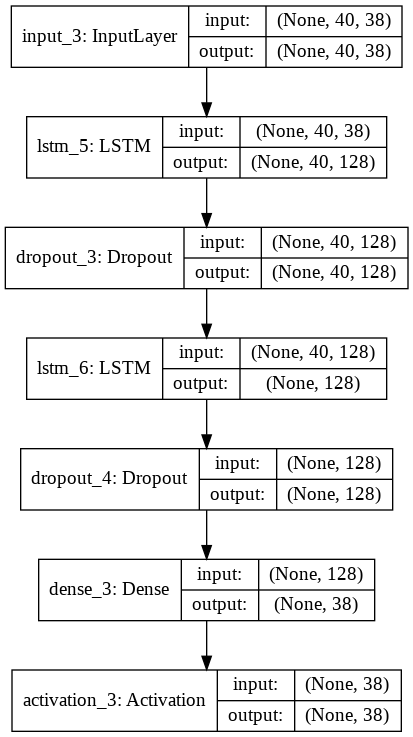

In [15]:
plot_model(model, to_file = "model.png", show_shapes = True)

In [16]:
print_callback = LambdaCallback(on_epoch_end = on_epoch_end)
model.fit(x, y, batch_size = 128, epochs = 1, callbacks = [print_callback])

ValueError: ignored